# Generating random NN models with different baseline structures

2019.11.1
Stephen Wu

Goal of this script: 
sample codes of generating random neural network models based on a few different baseline structures other than the basic ones shown in the XenonPy official tutorial.
    1. fixing the range of number of neurons in the first and last hidden layer with linear reduction of the range from the first to the last layer.
    2. fixing the range of number of neurons in the first and last hidden layer with log reduction of the range from the first to the last layer.
    3. randomly picking a subset of descriptors from the full descriptors as input for each neural network
    
Data from Pubchem (a subset selected by Ikebata) is used as an example.

### Preparation

In [2]:
import pandas as pd
import numpy as np
import pickle as pk

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##### Load files

You can download the in-house data at https://github.com/yoshida-lab/XenonPy/releases/download/v0.4.1/iQSPR_sample_data.csv

In [3]:
# load QM9 data from csv file
data = pd.read_csv('./iQSPR_sample_data.csv')

# take a look at the data
print(data.columns)
print(data.shape)
data.head()

Index(['Unnamed: 0', 'SMILES', 'E', 'HOMO-LUMO gap'], dtype='object')
(16674, 4)


,Unnamed: 0,SMILES,E,HOMO-LUMO gap
0,1,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,177.577,4.352512
1,2,CC(=O)OC(CC(=O)O)C[N+](C)(C)C,185.735,7.513497
2,3,C1=CC(C(C(=C1)C(=O)O)O)O,98.605,4.581348
3,4,CC(CN)O,83.445,8.034841
4,5,C(C(=O)COP(=O)(O)O)N,90.877,5.741310


##### Fingerprints

In [4]:
from xenonpy.descriptor import Fingerprints

FPs_ECFP_MACCS = Fingerprints(featurizers=['ECFP','MACCS'], input_type='smiles', on_errors='nan')
FPs_All = Fingerprints(featurizers=['RDKitFP','AtomPairFP','TopologicalTorsionFP','ECFP','FCFP','MACCS'], input_type='smiles', on_errors='nan')


### Train DNN models


##### 1. fixing the range of number of neurons in the first and last hidden layer with linear reduction of the range from the first to the last layer.
##### 2. fixing the range of number of neurons in the first and last hidden layer with log reduction of the range from the first to the last layer.

roughly takes 1min

In [18]:
%%time

# pick a property as output
prop = data['HOMO-LUMO gap'].to_frame()
# pre-calculate all descriptors
desc = FPs_ECFP_MACCS.transform(data['SMILES'])
# remove NaN row
prop = prop[~desc.isnull().any(axis=1)]
desc = desc[~desc.isnull().any(axis=1)]


CPU times: user 9.18 s, sys: 764 ms, total: 9.94 s
Wall time: 16.5 s


prepare a function to generate random number of neurons uniformly from a given range at each hidden layer for a given total number of layer, for which the max and min values of the ranges are linearly decaying with a pair of fixed max and min values at the first and the last hidden layer.

In [5]:
# the fixed max and min values at the first and the last hidden layer 
# are determined empirically based on the length of the descriptor

def neuron_vector_lin(nL):
    max_vec = np.linspace(1500,100,nL)
    min_vec = np.linspace(1000,20,nL)
    return sorted([np.random.randint(min_vec[i], max_vec[i]) for i in range(nL)], reverse=True)


In [6]:
# test the function
for _ in range(10):
    neuron_vector_lin(5)


[1201, 933, 564, 274, 89]

[1113, 939, 682, 291, 70]

[1121, 1008, 590, 448, 30]

[1104, 1041, 792, 436, 66]

[1235, 974, 793, 298, 65]

[1433, 885, 534, 424, 89]

[1319, 787, 595, 400, 32]

[1476, 846, 799, 316, 56]

[1019, 1015, 628, 397, 69]

[1353, 871, 513, 307, 43]

prepare a function to generate random number of neurons uniformly from a given range at each hidden layer for a given total number of layer, for which the max and min values of the ranges are decaying in log-scale with a pair of fixed max and min values at the first and the last hidden layer.

In [7]:
# the fixed max and min values at the first and the last hidden layer 
# are determined empirically based on the length of the descriptor

def neuron_vector_log(nL):
    log_base = 2
    max_vec = np.round(np.logspace(np.log2(100),np.log2(1500),nL,base=log_base))
    min_vec = np.round(np.logspace(np.log2(20),np.log2(1000),nL,base=log_base))
    return sorted([np.random.randint(min_vec[i], max_vec[i]) for i in range(nL)], reverse=True)


In [8]:
# test the function
for _ in range(10):
    neuron_vector_log(5)
    

[1454, 723, 255, 101, 41]

[1142, 617, 257, 80, 80]

[1235, 513, 299, 160, 85]

[1397, 540, 184, 183, 74]

[1188, 410, 193, 127, 81]

[1109, 669, 358, 115, 42]

[1475, 467, 325, 119, 24]

[1018, 565, 232, 139, 62]

[1419, 524, 263, 85, 61]

[1180, 731, 212, 151, 79]

prepare a generator with a selected "neuron_vector" function (we use LeakyReLu in this example)

In [9]:
from torch.nn import LeakyReLU
from xenonpy.utils import ParameterGenerator

generator = ParameterGenerator(
    in_features=desc.shape[1],
    out_features=1,
    h_neurons=dict(
        data=neuron_vector_lin, 
        repeat=(3, 4, 5)
    ),
    h_activation_funcs=(LeakyReLU(),)
)

In [10]:
# test the function

for parameters in generator(num=5):
    print(parameters)
    

{'in_features': 2215, 'out_features': 1, 'h_activation_funcs': LeakyReLU(negative_slope=0.01), 'h_neurons': (1106, 944, 457, 57)}
{'in_features': 2215, 'out_features': 1, 'h_activation_funcs': LeakyReLU(negative_slope=0.01), 'h_neurons': (1092, 1016, 483, 91)}
{'in_features': 2215, 'out_features': 1, 'h_activation_funcs': LeakyReLU(negative_slope=0.01), 'h_neurons': (1365, 739, 401, 42)}
{'in_features': 2215, 'out_features': 1, 'h_activation_funcs': LeakyReLU(negative_slope=0.01), 'h_neurons': (1243, 846, 616, 439, 73)}
{'in_features': 2215, 'out_features': 1, 'h_activation_funcs': LeakyReLU(negative_slope=0.01), 'h_neurons': (1433, 1071, 611, 287, 32)}


prepare a function to automatically generate names for each model

In [11]:
def make_name(model):
    name = ['HLgap']
    for n, m in model.named_children():
        if 'layer_' in n:
            name.append(str(m.linear.in_features))
        else:
            name.append(str(m.in_features))
            name.append(str(m.out_features))
    return '-'.join(name)


In [14]:
# test the function
from xenonpy.model import SequentialLinear, LinearLayer

for paras, model in generator(num=3, factory=SequentialLinear):
    print(make_name(model))
    

HLgap-2215-1272-917-651-278-77-1
HLgap-2215-1026-902-507-49-1
HLgap-2215-1320-825-759-305-55-1


training models

In [15]:
# import libraries
import torch
from torch.utils.data import DataLoader

from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

from xenonpy.model import SequentialLinear, LinearLayer
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipValue
from xenonpy.model.training.extension import Validator, TensorConverter, Persist
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.model.utils import regression_metrics

from collections import OrderedDict

In [16]:
# prepare a trainer
trainer = Trainer(
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
    cuda=False,
).extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=50, trace_order=3, mae=0.0, pearsonr=1.0),
)


In [ ]:
summary = []
save_folder = 'Test_HLgap_MACCSECFP'
N_train = int(prop.shape[0]*0.8)
train_batch_size = 512 # based on total number data
test_batch_size = 1024 # based on total number data
max_epochs = 200

for paras, model in generator(num=100, factory=SequentialLinear):
    sp = Splitter(prop.shape[0], test_size=prop.shape[0]-N_train)
    x_train, x_val, y_train, y_val = sp.split(desc, prop)
    
    train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=train_batch_size)
    val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=test_batch_size)
    
    model_name = make_name(model)
    persist = Persist(
        f'{save_folder}/{model_name}', 
        # -^- required -^-
        
        # -v- optional -v-
        increment=True, 
        sync_training_step=True,
        model_class=SequentialLinear,
        model_params=paras,
        author='Someone',
        email='someone@email.com',
        dataset='Pubchem_ikebata',
    )
    _ = trainer.extend(persist)
    trainer.reset(to=model)
    
    trainer.fit(training_dataset=train_dataset, validation_dataset=val_dataset, epochs=max_epochs)
    persist(splitter=sp, data_indices=prop.index.tolist())  # <-- calling of this method only after the model training
    
    training_info = trainer.training_info
    
    summary.append(OrderedDict(
        id=model_name,
        mae=training_info['val_mae'].min(),
        mse=training_info['val_mse'].min(),
        r2=training_info['val_r2'].max(),
        corr=training_info['val_pearsonr'].max(),
        spearman_corr=training_info['val_spearmanr'].max(),
    ))
    
# record the summary of the results
summary = pd.DataFrame(summary)
summary.to_pickle(f'{save_folder}/summary.pd.xz')


Training:   8%|▊         | 15/200 [02:03<25:27,  8.26s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 391


Training:  12%|█▎        | 25/200 [03:01<21:08,  7.25s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 664


Training:   4%|▍         | 8/200 [00:55<22:16,  6.96s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 197


Training:   5%|▌         | 10/200 [01:07<21:22,  6.75s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 262


Training:  10%|▉         | 19/200 [03:29<33:17, 11.04s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 508


Training:  12%|█▏        | 23/200 [03:15<25:05,  8.51s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 610


Training:   6%|▌         | 11/200 [01:43<29:32,  9.38s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 291


Training:   4%|▎         | 7/200 [00:54<25:13,  7.84s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 179


Training:  11%|█         | 22/200 [03:02<24:37,  8.30s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 588


Training:   6%|▋         | 13/200 [01:46<25:25,  8.16s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 337


Training:  13%|█▎        | 26/200 [04:11<28:04,  9.68s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 690


Training:  10%|▉         | 19/200 [02:13<21:14,  7.04s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 509


Training:   3%|▎         | 6/200 [01:09<37:24, 11.57s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 158


Training:   4%|▍         | 8/200 [01:01<24:24,  7.63s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 207


Training:   7%|▋         | 14/200 [02:02<27:08,  8.75s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 367


Training:   4%|▍         | 9/200 [01:31<32:11, 10.11s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 235


Training:   6%|▌         | 12/200 [02:07<33:23, 10.66s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 312


Training:  10%|█         | 21/200 [02:25<20:42,  6.94s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 554


Training:   9%|▉         | 18/200 [02:46<28:02,  9.24s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 472


Training:   9%|▉         | 18/200 [02:33<25:51,  8.53s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 478


Training:   4%|▍         | 9/200 [01:16<27:11,  8.54s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 239


Training:   8%|▊         | 15/200 [01:35<19:39,  6.38s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 395


Training:   8%|▊         | 17/200 [02:12<23:46,  7.80s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 450


Training:   4%|▍         | 9/200 [01:08<24:11,  7.60s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 240


Training:   5%|▌         | 10/200 [01:01<19:35,  6.19s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 265


Training:  11%|█         | 22/200 [03:12<26:01,  8.77s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 589


Training:   7%|▋         | 14/200 [01:42<22:43,  7.33s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 363


Training:   5%|▌         | 10/200 [01:07<21:17,  6.72s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 253


Training:   4%|▍         | 9/200 [01:09<24:41,  7.75s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 238


Training:  10%|█         | 21/200 [02:57<25:11,  8.45s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 558


Training:   4%|▍         | 8/200 [00:56<22:40,  7.08s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 195


Training:  10%|█         | 20/200 [02:31<22:47,  7.60s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 538


Training:  10%|█         | 20/200 [02:05<18:46,  6.26s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 534


Training:   6%|▌         | 11/200 [01:39<28:28,  9.04s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 293


Training:   8%|▊         | 16/200 [01:55<22:12,  7.24s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 427


Training:   8%|▊         | 17/200 [02:14<24:02,  7.88s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 454


Training:   4%|▍         | 8/200 [01:00<24:12,  7.56s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 215


Training:   6%|▋         | 13/200 [01:51<26:36,  8.54s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 346


Training:  12%|█▏        | 24/200 [03:23<24:53,  8.48s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 639


Training:   8%|▊         | 17/200 [02:01<21:49,  7.16s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 454


Training:   8%|▊         | 15/200 [02:00<24:44,  8.02s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 398


Training:   6%|▌         | 12/200 [01:52<29:16,  9.34s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 315


Training:   8%|▊         | 15/200 [02:11<27:02,  8.77s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 398


Training:  10%|█         | 21/200 [02:28<21:09,  7.09s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 562


Training:  10%|█         | 20/200 [02:48<25:18,  8.43s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 532


Training:  10%|█         | 21/200 [03:10<27:02,  9.06s/it]


Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 562


Training:   6%|▌         | 11/200 [01:14<22:50,  7.25s/it]

plot training results

In [6]:
# prepare target and plotting folders, and load models
import os
from xenonpy.model.training import Checker

target_folder = 'Test_HLgap_MACCSECFP'
save_plots = 'Plots_' + target_folder

if not os.path.exists(save_plots):
    os.makedirs(save_plots)

checkers = []
model_list = []
tmp_file = os.listdir(target_folder)
for tmp in tmp_file:
    if os.path.isdir(f'{target_folder}/{tmp}'):
        model_list.append(tmp)
        checkers.append(Checker(f'{target_folder}/{tmp}'))


In [7]:
# prediction vs. observation plots (single test trial)
import seaborn as sb

def draw(y_true, y_pred, y_true_fit=None, y_pred_fit=None, *, prop_name, log_scale=False, file_dir=None, file_name=None):

    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
        
    data = pd.DataFrame(dict(Observation=y_true, Prediction=y_pred, dataset=['test'] * len(y_true)))
    scores = metrics(data['Observation'], data['Prediction'])
    
    if y_true_fit is not None and y_pred_fit is not None:
        mask = ~np.isnan(y_pred_fit)
        y_true_fit = y_true_fit[mask]
        y_pred_fit = y_pred_fit[mask]
        train_ = pd.DataFrame(dict(Observation=y_true_fit, Prediction=y_pred_fit, dataset=['train'] * len(y_true_fit)))
        data = pd.concat([train_, data])

    if log_scale:
        data = data.apply(lambda c: np.log(c.values) if c.dtype.type is not np.object_ else c, axis=0)
#         test_ = test_.apply(lambda c: np.log(c.values) if c.dtype.type is not np.object_ else c, axis=0)



#     with sb.set(font_scale=2.5):
    g = sb.lmplot(x="Prediction", y="Observation", hue="dataset", ci=None,
                  data=data, palette="Set1", height=10, legend=False,  markers=[".", "o"],
                  scatter_kws={'s': 25, 'alpha': 0.7}, hue_order=['train', 'test'])
    
    ax = plt.gca()
    tmp = [data["Prediction"].max(), data["Prediction"].min(), data["Observation"].max(), data["Observation"].max()]
    min_, max_ = np.min(tmp), np.max(tmp)
    margin = (max_- min_) / 15
    min_ = min_ - margin
    max_ = max_ + margin
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_xlabel(ax.get_xlabel(), fontsize='xx-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='xx-large')
    ax.tick_params(axis='both', which='major', labelsize='xx-large')
    ax.plot((min_, max_), (min_, max_), ':', color='gray')
    ax.set_title(prop_name, fontsize='xx-large')
    if log_scale:
        ax.set_title(prop_name + ' (log scale)', fontsize='xx-large')
    ax.text(0.98, 0.03,
            'MAE: %.5f\nRMSE: %.5f\nPearsonR: %.5f\nSpearmanR: %.5f' % (scores['mae'], scores['rmse'], scores['pearsonr'], scores['spearmanr']),
            transform=ax.transAxes, horizontalalignment='right', fontsize='xx-large')

    ax.legend(loc='upper left', markerscale=2, fancybox=True, shadow=True, frameon=True, facecolor='w', fontsize=18)

    plt.tight_layout()
    if file_dir and file_name:
        if log_scale:
            plt.savefig(file_dir + '/' + file_name + '_log_scale.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(file_dir + '/' + file_name + '.png', dip=300, bbox_inches='tight')
    else:
        print('Missing directory and/or file name information!')
        
# calculating basic statistics for predictions
def metrics(y_true, y_pred, ignore_nan=True):
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    from scipy.stats import pearsonr, spearmanr
    
    if ignore_nan:
        mask = ~np.isnan(y_pred)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    pr, p_val = pearsonr(y_true, y_pred)
    sr, _ = spearmanr(y_true, y_pred)
    return dict(
        mae=mae,
        rmse=rmse,
        r2=r2,
        pearsonr=pr,
        spearmanr=sr,
        p_value=p_val
    )

RuntimeError: size mismatch, m1: [1024 x 10407], m2: [567 x 502] at /Users/distiller/project/conda/conda-bld/pytorch_1556653464916/work/aten/src/TH/generic/THTensorMath.cpp:961

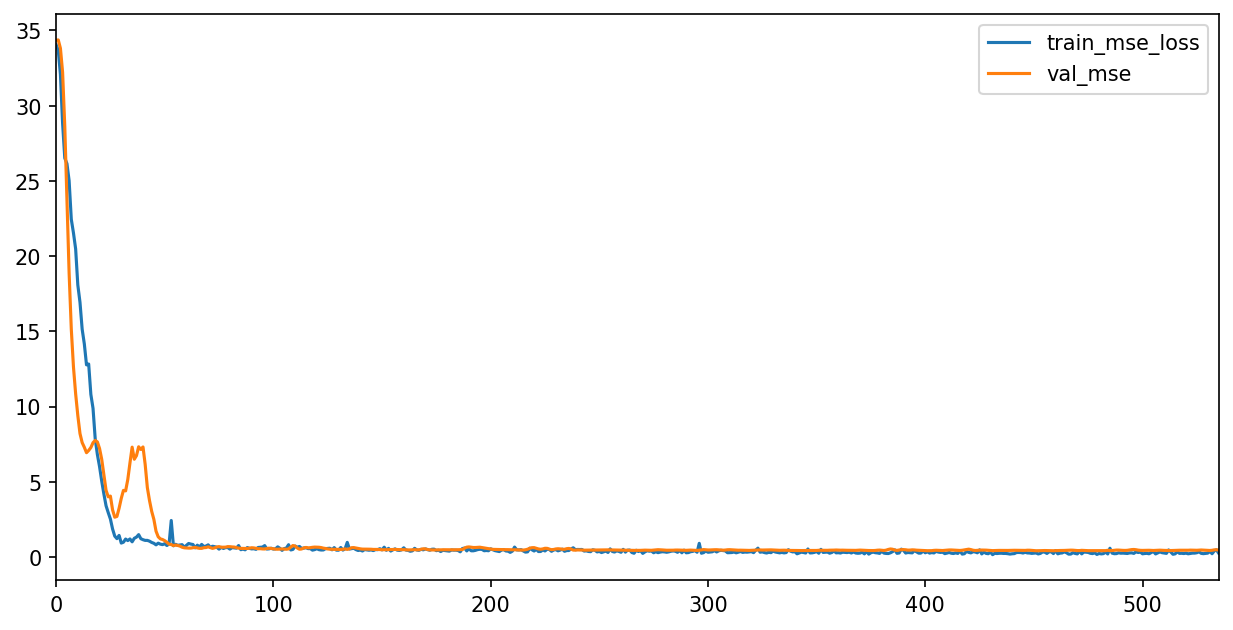

In [9]:
# plot training loss (based on the best mae among the three traced models)
import matplotlib.pyplot as plt
from xenonpy.model.training import Trainer
from xenonpy.model.training.dataset import ArrayDataset
from torch.utils.data import DataLoader
from xenonpy.model.training.extension import TensorConverter

train_batch_size = 512 # based on total number data
test_batch_size = 1024 # based on total number data

for i, checker in enumerate(checkers):
    # plot training loss
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
    trainer = Trainer.load(from_=checker).extend(TensorConverter())
    _ = trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)
    fig.savefig(f'{save_plots}/Train_{model_list[i]}')
    
    # plot observation vs. prediction (based on the best mae among the three traced models)
    sp = checker['splitter']
    x_train, x_val, y_train, y_val = sp.split(desc, prop)
    
    train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=train_batch_size)
    val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=test_batch_size)
    
    y_pred, y_true = trainer.predict(dataset=val_dataset, checkpoint='mae_1')
    y_fit_pred, y_fit_true = trainer.predict(dataset=train_dataset, checkpoint='mae_1')
    draw(y_true, y_pred, y_fit_true, y_fit_pred, prop_name='HL gap',file_dir=save_plots, file_name='P2O_'+model_list[i])
    

##### 3. randomly picking a subset of descriptors from the full descriptors as input for each neural network

roughly takes 2-3mins

In [5]:
%%time

# pick a property as output
prop = data['HOMO-LUMO gap'].to_frame()
# pre-calculate all descriptors
desc = FPs_All.transform(data['SMILES'])
# remove NaN row
prop = prop[~desc.isnull().any(axis=1)]
desc = desc[~desc.isnull().any(axis=1)]


CPU times: user 56.4 s, sys: 6.77 s, total: 1min 3s
Wall time: 2min 20s


prepare a function to generate random number of neurons uniformly from a given range at each hidden layer for a given total number of layer, for which the max and min values of the ranges are linearly decaying with a pair of fixed max and min values at the first and the last hidden layer determined based on fractions of the input dimension.

In [6]:
# the fixed max and min ratio at the first and the last hidden layer 
# are determined empirically based on the length of the descriptor

def neuron_vector(nL, in_neu):
    max_vec = np.linspace(int(in_neu*0.9),100,nL)
    min_vec = np.linspace(int(in_neu*0.7),10,nL)
    return sorted([np.random.randint(min_vec[i], max_vec[i]) for i in range(nL)], reverse=True)


In [7]:
# test the function
for _ in range(10):
    neuron_vector(5, 600)
    

[502, 385, 247, 201, 31]

[454, 363, 280, 124, 56]

[458, 424, 229, 173, 96]

[423, 361, 282, 201, 62]

[486, 332, 312, 121, 30]

[529, 379, 278, 117, 13]

[471, 348, 226, 165, 13]

[470, 364, 280, 134, 83]

[480, 334, 245, 169, 37]

[520, 337, 263, 167, 52]

prepare a function to automatically generate names for each model

In [8]:
def make_name(model):
    name = ['HLgap']
    for n, m in model.named_children():
        if 'layer_' in n:
            name.append(str(m.linear.in_features))
        else:
            name.append(str(m.in_features))
            name.append(str(m.out_features))
    return '-'.join(name)

training models (this time the generator is greated inside the loop)

In [14]:
# import libraries
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

from torch.nn import LeakyReLU
from xenonpy.utils import ParameterGenerator

from xenonpy.model import SequentialLinear, LinearLayer
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipValue
from xenonpy.model.training.extension import Validator, TensorConverter, Persist
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.model.utils import regression_metrics

from collections import OrderedDict

In [15]:
trainer = Trainer(
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
    cuda=False,
).extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=50, trace_order=3, mae=0.0, pearsonr=1.0),
)

In [16]:
summary = []
save_folder = 'Test_HLgap_RandFP500to1k'
N_train = int(prop.shape[0]*0.8)
train_batch_size = 512 # based on total number data
test_batch_size = 1024 # based on total number data
max_epochs = 200
N_desc_range = (500, 1000)

for _ in range(100):
    
    sp = Splitter(prop.shape[0], test_size=prop.shape[0]-N_train)
    x_train, x_val, y_train, y_val = sp.split(desc, prop)
    
    # remove all-0 or all-1 columns based on the training set
    x_train = x_train.loc[:, (x_train != 0).any(axis=0)]
    x_train = x_train.loc[:, (x_train != 1).any(axis=0)]
    
    # randomly pick a subset of descriptors
    x_train = x_train.sample(min(np.random.randint(N_desc_range[0],N_desc_range[1]+1), x_train.shape[1]), axis=1)
    x_val = x_val[x_train.columns]
    
    train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=train_batch_size)
    val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=test_batch_size)
    
    print('Number of descriptors picked: ',len(x_train.columns))
    
    # prepare generator here
    generator = ParameterGenerator(
        in_features=x_train.shape[1],
        out_features=1,
        h_neurons=dict(
            data=lambda x: neuron_vector(x, x_train.shape[1]), 
            repeat=(3, 4, 5)
        ),
        h_activation_funcs=(LeakyReLU(),)
    )
    
    # get one random model from the generator
    paras, model = next(generator(num=1,factory=SequentialLinear))
    
    model_name = make_name(model)
    persist = Persist(
        f'{save_folder}/{model_name}', 
        # -^- required -^-
        
        # -v- optional -v-
        increment=True, 
        sync_training_step=True,
        model_class=SequentialLinear,
        model_params=paras,
        author='Someone',
        email='someone@email.com',
        dataset='Pubchem_ikebata',
    )
    _ = trainer.extend(persist)
    trainer.reset(to=model)
    
    trainer.fit(training_dataset=train_dataset, validation_dataset=val_dataset, epochs=max_epochs)
    # make sure we record the column names of the descriptors that we have picked!
    persist(splitter=sp, data_indices=prop.index.tolist(), x_colnames=x_train.columns)  # <-- calling of this method only after the model training
    
    training_info = trainer.training_info
    
    summary.append(OrderedDict(
        id=model_name,
        mae=training_info['val_mae'].min(),
        mse=training_info['val_mse'].min(),
        r2=training_info['val_r2'].max(),
        corr=training_info['val_pearsonr'].max(),
        spearman_corr=training_info['val_spearmanr'].max(),
    ))

# record the summary of the results
summary = pd.DataFrame(summary)
summary.to_pickle(f'{save_folder}/summary.pd.xz')


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Number of descriptors picked:  567


Training:   4%|▍         | 20/500 [02:13<53:32,  6.69s/it]

Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 51 iterations, finish training at iteration 536


plot training results

In [10]:
# prepare target and plotting folders, and load models
import os
from xenonpy.model.training import Checker

target_folder = 'Test_HLgap_RandFP500to1k'
save_plots = 'Plots_' + target_folder

if not os.path.exists(save_plots):
    os.makedirs(save_plots)

checkers = []
model_list = []
tmp_file = os.listdir(target_folder)
for tmp in tmp_file:
    if os.path.isdir(f'{target_folder}/{tmp}'):
        model_list.append(tmp)
        checkers.append(Checker(f'{target_folder}/{tmp}'))


In [18]:
# prediction vs. observation plots (single test trial)
import seaborn as sb

def draw(y_true, y_pred, y_true_fit=None, y_pred_fit=None, *, prop_name, log_scale=False, file_dir=None, file_name=None):

    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
        
    data = pd.DataFrame(dict(Observation=y_true, Prediction=y_pred, dataset=['test'] * len(y_true)))
    scores = metrics(data['Observation'], data['Prediction'])
    
    if y_true_fit is not None and y_pred_fit is not None:
        mask = ~np.isnan(y_pred_fit)
        y_true_fit = y_true_fit[mask]
        y_pred_fit = y_pred_fit[mask]
        train_ = pd.DataFrame(dict(Observation=y_true_fit, Prediction=y_pred_fit, dataset=['train'] * len(y_true_fit)))
        data = pd.concat([train_, data])

    if log_scale:
        data = data.apply(lambda c: np.log(c.values) if c.dtype.type is not np.object_ else c, axis=0)
#         test_ = test_.apply(lambda c: np.log(c.values) if c.dtype.type is not np.object_ else c, axis=0)



#     with sb.set(font_scale=2.5):
    g = sb.lmplot(x="Prediction", y="Observation", hue="dataset", ci=None,
                  data=data, palette="Set1", height=10, legend=False,  markers=[".", "o"],
                  scatter_kws={'s': 25, 'alpha': 0.7}, hue_order=['train', 'test'])
    
    ax = plt.gca()
    tmp = [data["Prediction"].max(), data["Prediction"].min(), data["Observation"].max(), data["Observation"].max()]
    min_, max_ = np.min(tmp), np.max(tmp)
    margin = (max_- min_) / 15
    min_ = min_ - margin
    max_ = max_ + margin
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_xlabel(ax.get_xlabel(), fontsize='xx-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='xx-large')
    ax.tick_params(axis='both', which='major', labelsize='xx-large')
    ax.plot((min_, max_), (min_, max_), ':', color='gray')
    ax.set_title(prop_name, fontsize='xx-large')
    if log_scale:
        ax.set_title(prop_name + ' (log scale)', fontsize='xx-large')
    ax.text(0.98, 0.03,
            'MAE: %.5f\nRMSE: %.5f\nPearsonR: %.5f\nSpearmanR: %.5f' % (scores['mae'], scores['rmse'], scores['pearsonr'], scores['spearmanr']),
            transform=ax.transAxes, horizontalalignment='right', fontsize='xx-large')

    ax.legend(loc='upper left', markerscale=2, fancybox=True, shadow=True, frameon=True, facecolor='w', fontsize=18)

    plt.tight_layout()
    if file_dir and file_name:
        if log_scale:
            plt.savefig(file_dir + '/' + file_name + '_log_scale.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(file_dir + '/' + file_name + '.png', dip=300, bbox_inches='tight')
    else:
        print('Missing directory and/or file name information!')
        
# calculating basic statistics for predictions
def metrics(y_true, y_pred, ignore_nan=True):
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    from scipy.stats import pearsonr, spearmanr
    
    if ignore_nan:
        mask = ~np.isnan(y_pred)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    pr, p_val = pearsonr(y_true, y_pred)
    sr, _ = spearmanr(y_true, y_pred)
    return dict(
        mae=mae,
        rmse=rmse,
        r2=r2,
        pearsonr=pr,
        spearmanr=sr,
        p_value=p_val
    )

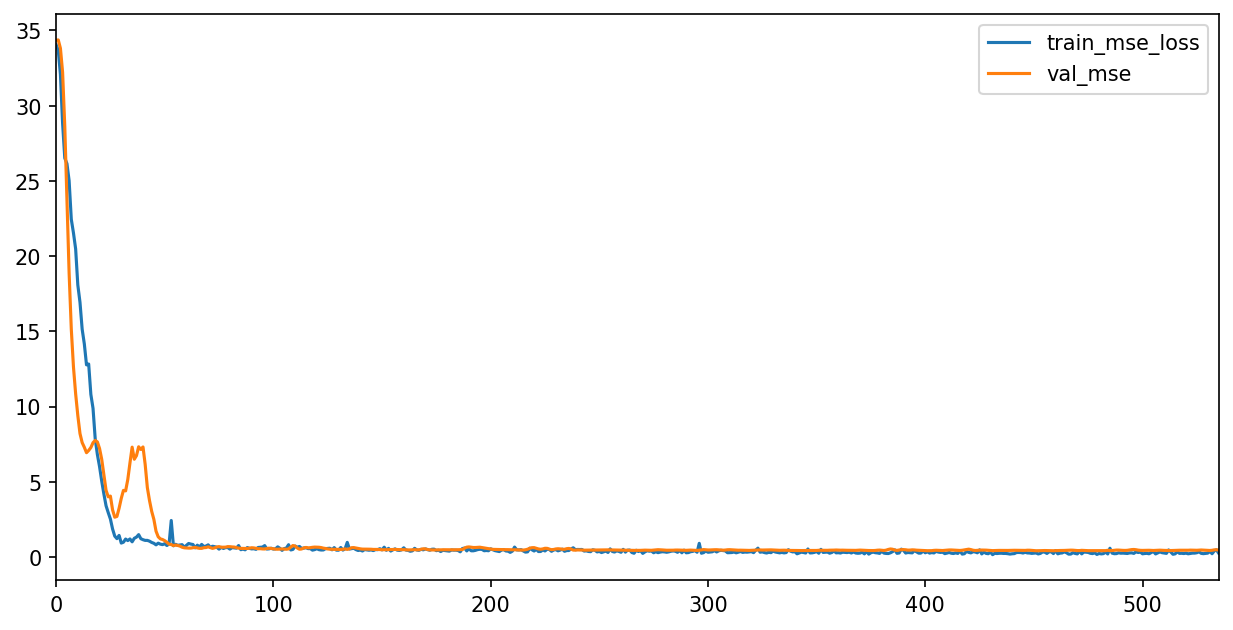

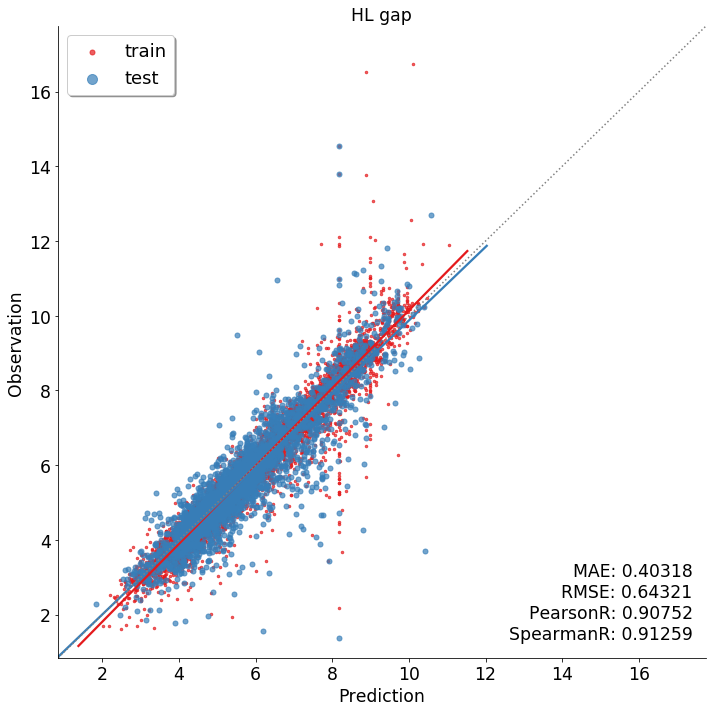

In [21]:
# plot training loss (based on the best mae among the three traced models)
import matplotlib.pyplot as plt
from xenonpy.model.training import Trainer
from xenonpy.model.training.dataset import ArrayDataset
from torch.utils.data import DataLoader
from xenonpy.model.training.extension import TensorConverter

train_batch_size = 512 # based on total number data
test_batch_size = 1024 # based on total number data

for i, checker in enumerate(checkers):
    # plot training loss
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
    trainer = Trainer.load(from_=checker).extend(TensorConverter())
    _ = trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)
    fig.savefig(f'{save_plots}/Train_{model_list[i]}')
    
    # plot observation vs. prediction (based on the best mae among the three traced models)
    sp = checker['splitter']
    x_train, x_val, y_train, y_val = sp.split(desc, prop)
    
    x_colnames = checker['x_colnames']
    x_train = x_train[x_colnames]
    x_val = x_val[x_colnames]
    
    train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=train_batch_size)
    val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=test_batch_size)
    
    y_pred, y_true = trainer.predict(dataset=val_dataset, checkpoint='mae_1')
    y_fit_pred, y_fit_true = trainer.predict(dataset=train_dataset, checkpoint='mae_1')
    draw(y_true, y_pred, y_fit_true, y_fit_pred, prop_name='HL gap',file_dir=save_plots, file_name='P2O_'+model_list[i])
    